### FLiBe Simple

In [2]:
import openmc
import os, sys
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from matplotlib.ticker import MultipleLocator, ScalarFormatter
from scipy.interpolate import make_interp_spline
import imageio.v2 as iio # use v2 to avoid deprecation warnings --ppark

# Import helper functions
sys.path.insert(0, f"{Path.cwd()}/helper")
from utilities import *

MASS_U_LIST = [0, 0.1, 0.2, 0.5, 1, 2.5, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50] # metric tons uranium (MTU)
n_cells = len(MASS_U_LIST)

In [4]:
""" Read tallies and convert into usable forms """
sp = openmc.StatePoint('./model_Li6-20wt/statepoint.100.h5') # _Li6-7.5wt  _Li6-20wt

# Make directories for figures 
for sd in ['pdf','png','gif']:
    os.makedirs(f'./figures/{sd}/', exist_ok=True)

# Read tallies
flux_tally = sp.get_tally(name='flux')
U_tally    = sp.get_tally(name='uranium rxn rates')
Li_tally   = sp.get_tally(name='lithium rxn rates')
F_tally    = sp.get_tally(name='fluorine rxn rates') # unused
# Be_tally   = sp.get_tally(name='beryllium rxn rates')

# Sum over energy bins for total reaction rates
Li6_rxn_rates = Li_tally.summation(filter_type=openmc.EnergyFilter, nuclides=['Li6'], remove_filter=True)
Li7_rxn_rates = Li_tally.summation(filter_type=openmc.EnergyFilter, nuclides=['Li7'], remove_filter=True)
F19_rxn_rates = F_tally.summation(filter_type=openmc.EnergyFilter, nuclides=['F19'], remove_filter=True)
U235_rxn_rates = U_tally.summation(filter_type=openmc.EnergyFilter, nuclides=['U238'], remove_filter=True)
U238_rxn_rates = U_tally.summation(filter_type=openmc.EnergyFilter, nuclides=['U238'], remove_filter=True)
# print(Li6_rxn_rates.get_pandas_dataframe())

# Convert Tally objects into pandas dataframes
flux_df = flux_tally.get_pandas_dataframe() # Convert Tally object! Not 'XXX_rxn_rates'! --ppark
U_df    = U_tally.get_pandas_dataframe()
Li_df   = Li_tally.get_pandas_dataframe()
F_df    = F_tally.get_pandas_dataframe()

# Add new column for energy bin midpoint (for plotting) 
flux_df['energy mid [eV]'] = (flux_df['energy low [eV]'] + flux_df['energy high [eV]']) / 2
U_df['energy mid [eV]'] = (U_df['energy low [eV]'] + U_df['energy high [eV]']) / 2
Li_df['energy mid [eV]'] = (Li_df['energy low [eV]'] + Li_df['energy high [eV]']) / 2
F_df['energy mid [eV]'] = (F_df['energy low [eV]'] + F_df['energy high [eV]']) / 2

cell_ids = U_df['cell'].unique().tolist()
# print(flux_df)

#### Plotting the TBR

[1.0714986916550833, 1.0718515757929998, 1.0704048872507204, 1.0710578121810241, 1.0724911261949663, 1.071564015457679, 1.073177625348288, 1.0734350634966368, 1.0745954445397894, 1.0759837251098059, 1.0773581231228895, 1.0770567059729528, 1.079209579143191, 1.0814715436437456, 1.0825249916332909, 1.0841694812461427]


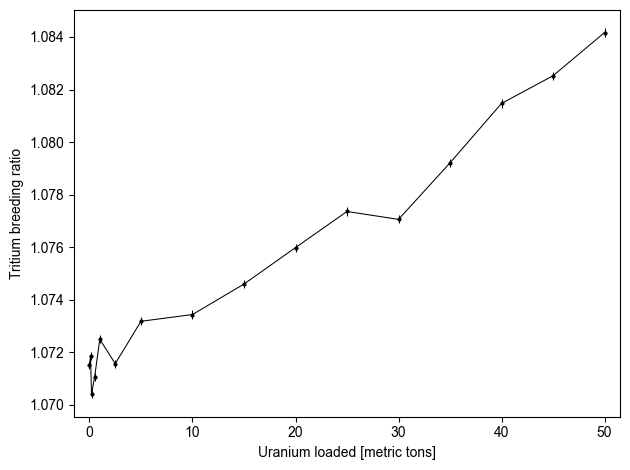

In [24]:
Li6_df = Li6_rxn_rates.get_pandas_dataframe()
Li6_nt_df = Li6_df[Li6_df['score'] == '(n,t)'][['cell', 'mean', 'std. dev.']]
# print(Li6_nt_df) # for debug --ppark 2025-07-05
tbr_list, tbr_err_list = Li6_nt_df['mean'].tolist(), Li6_nt_df['std. dev.'].tolist()
# tbr_list = Li6_rxn_rates.get_values(scores=['(n,t)'],value='mean').flatten().tolist() # same thing but I'm more familiar with pandas rn --ppark 2025-07-05
print(tbr_list)
plt.figure()
plt.errorbar(MASS_U_LIST, tbr_list, yerr=tbr_err_list, fmt='o-', markersize=2, capsize=0, linewidth=0.75, color='#000000',) # turn capsize > 0 to show error bars, but they're super smol
plt.xlim(-1.5,51.5)
# plt.ylim(1.0175,1.0725)
plt.xlabel('Uranium loaded [metric tons]')
plt.ylabel('Tritium breeding ratio')
plt.tight_layout()

# plt.savefig('./figures/pdf/fig_tbr.pdf', bbox_inches='tight', format='pdf')
# plt.savefig('./figures/png/fig_tbr.png', bbox_inches='tight', format='png')
plt.show()

#### Plutonium production rate

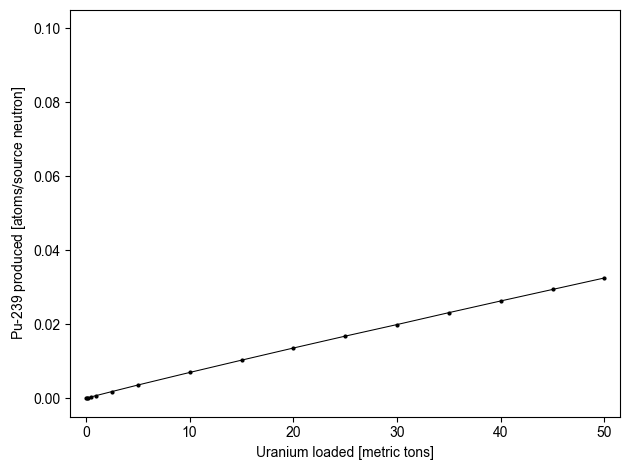

In [25]:
U238_df = U238_rxn_rates.get_pandas_dataframe()
U238_abs_df = U238_df[U238_df['score'] == '(n,gamma)'][['cell', 'mean', 'std. dev.']]
Pu_list, Pu_err_list = U238_abs_df['mean'].tolist(), U238_abs_df['std. dev.'].tolist()
# print(Pu_list) # for debug --ppark 2025-07-05

plt.figure()
plt.errorbar(MASS_U_LIST, Pu_list, yerr=Pu_err_list, fmt='o-', markersize=2, capsize=0, linewidth=0.75, color='#000000',) # turn capsize > 0 to show error bars, but they're super smol
plt.xlim(-1.5,51.5)
plt.ylim(-0.005,0.105)
plt.xlabel('Uranium loaded [metric tons]')
plt.ylabel(r'Pu-239 produced [atoms$/$source neutron]')
plt.tight_layout()

# plt.savefig('./figures/pdf/fig_Pu.pdf', bbox_inches='tight', format='pdf')
# plt.savefig('./figures/png/fig_Pu.png', bbox_inches='tight', format='png')
plt.show()

#### Plutonium production rate per MTU

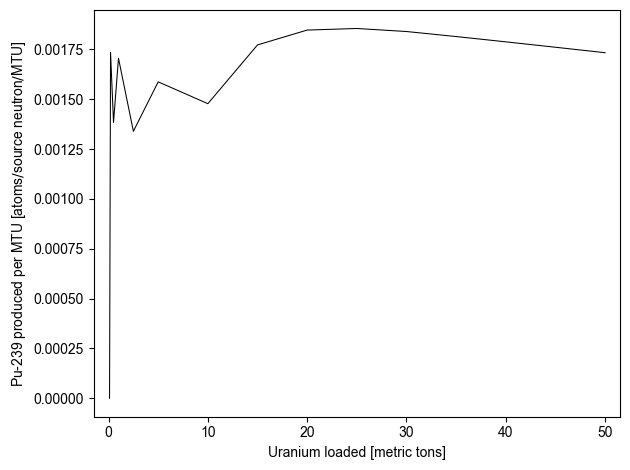

In [19]:
Pu_per_mtu_list = []
for i, m in enumerate(MASS_U_LIST[1:]):
    Pu_per_mtu_list.append(Pu_list[i]/m)
# print(Pu_list) # for debug --ppark 2025-07-05

plt.figure()
plt.plot(MASS_U_LIST[1:], Pu_per_mtu_list, markersize=2, linewidth=0.75, color='#000000',) # turn capsize > 0 to show error bars, but they're super smol
plt.xlim(-1.5,51.5)
# plt.ylim(-0.005,0.105)
plt.xlabel('Uranium loaded [metric tons]')
plt.ylabel(r'Pu-239 produced per MTU [atoms$/$source neutron$/$MTU]')
plt.tight_layout()

# plt.savefig('./figures/pdf/fig_Pu.pdf', bbox_inches='tight', format='pdf')
# plt.savefig('./figures/png/fig_Pu.png', bbox_inches='tight', format='png')
plt.show()

### Reaction rates
#### All reaction rates per U loading

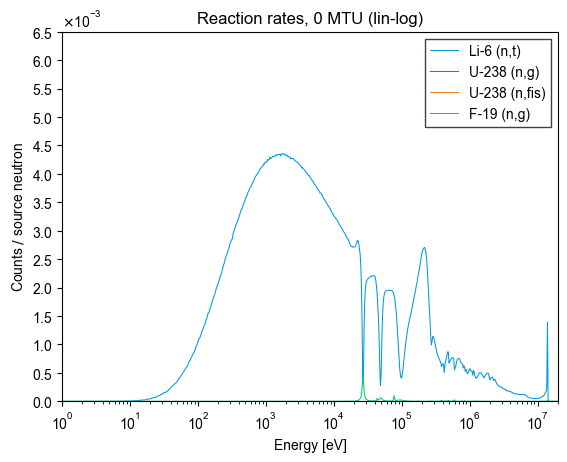

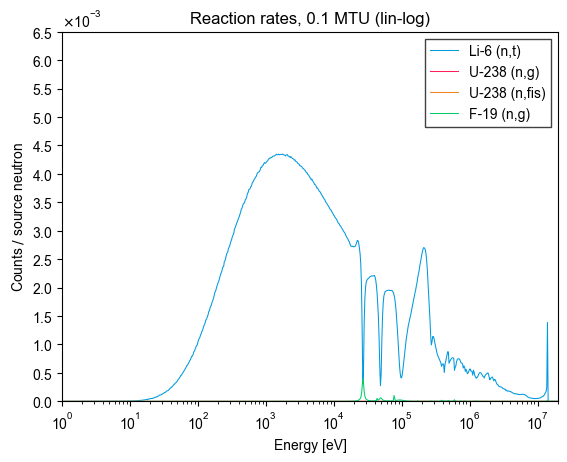

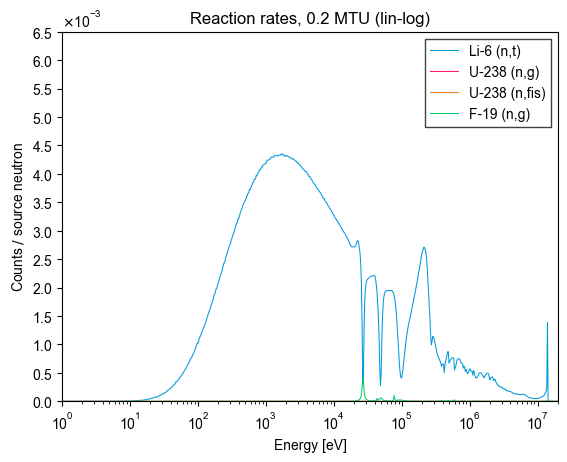

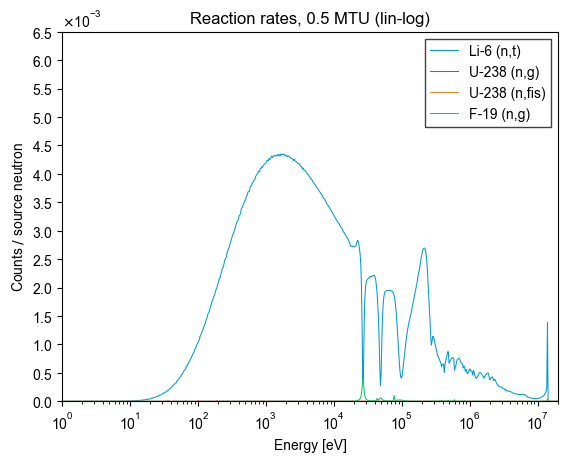

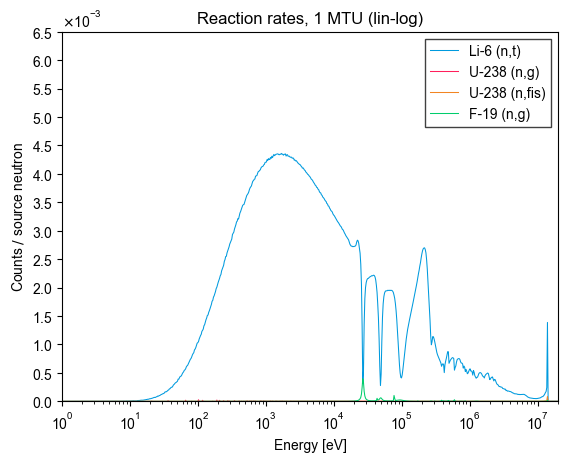

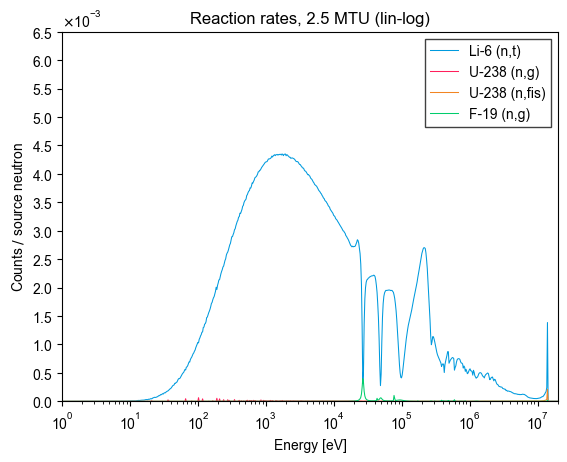

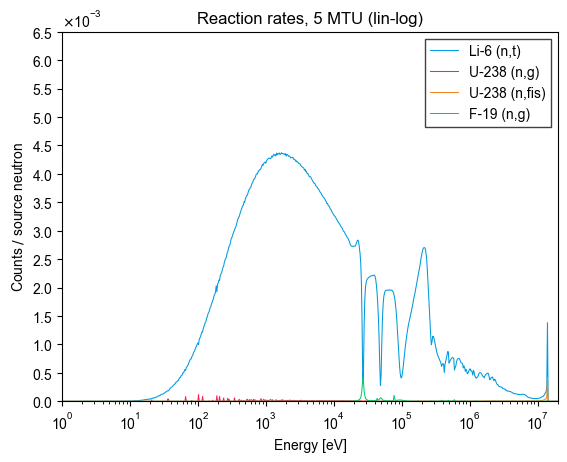

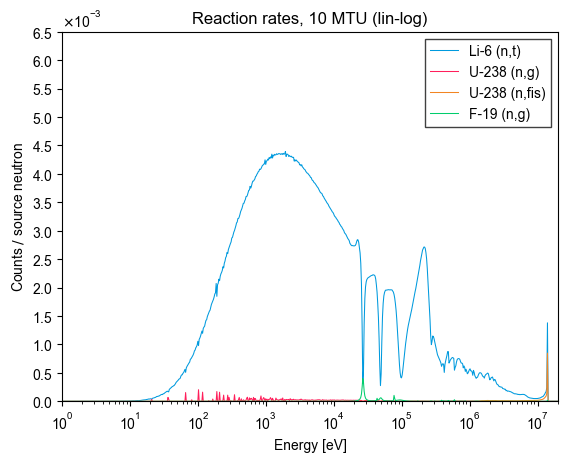

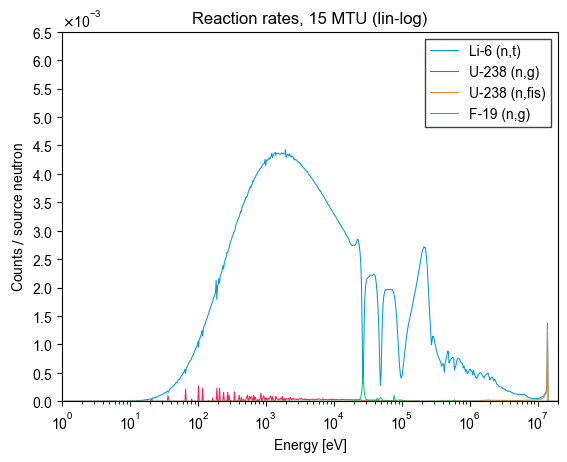

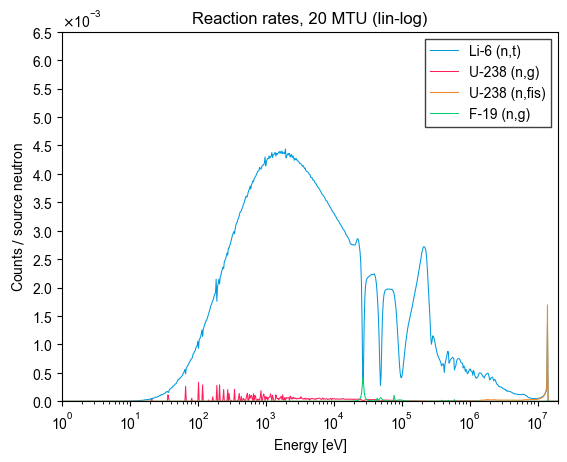

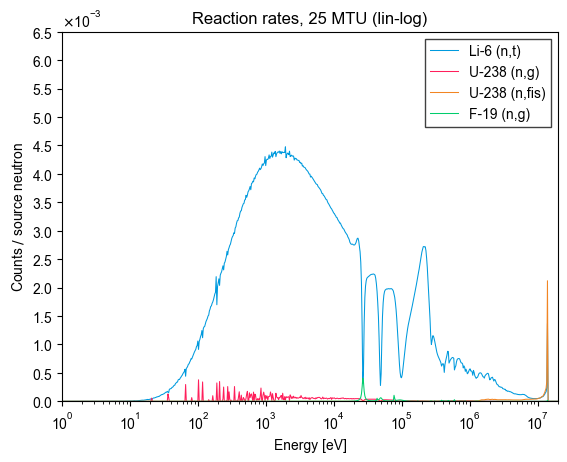

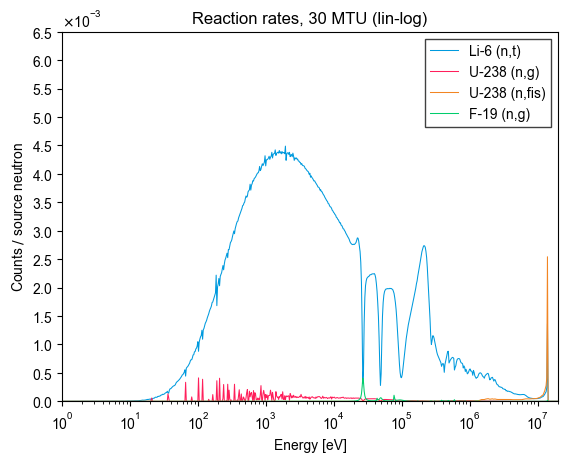

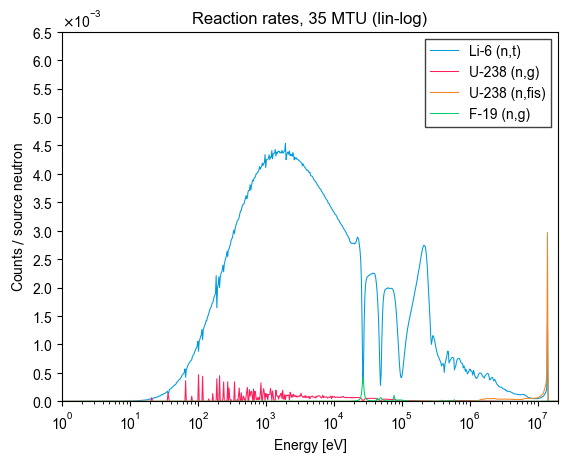

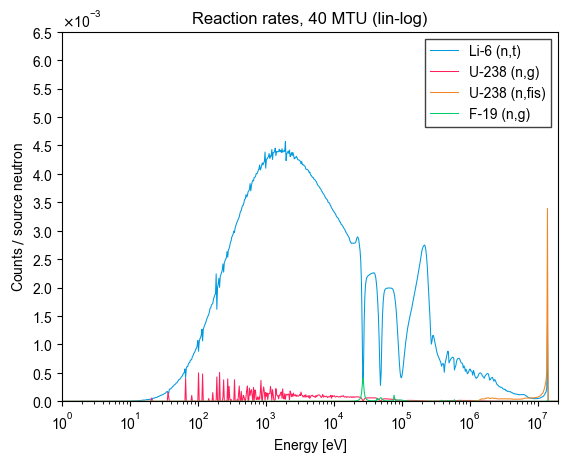

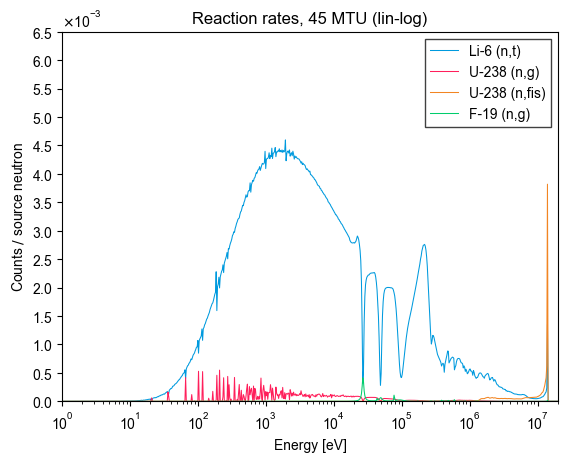

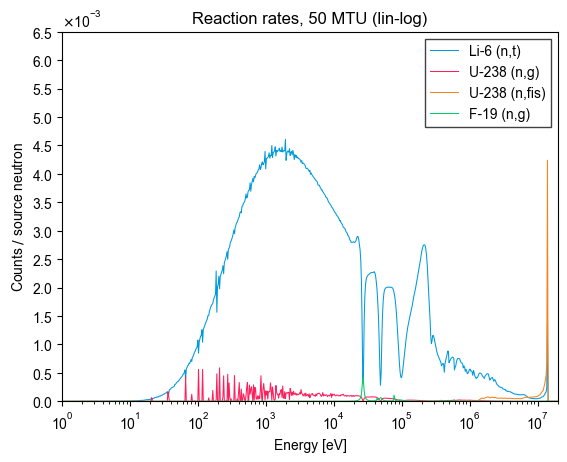

In [7]:
U238_abs_Ebin_df = U_df[(U_df['nuclide'] == 'U238') & (U_df['score'] == '(n,gamma)')][['energy mid [eV]', 'cell', 'mean', 'std. dev.']]
U238_fis_Ebin_df = U_df[(U_df['nuclide'] == 'U238') & (U_df['score'] == 'fission')][['energy mid [eV]', 'cell', 'mean', 'std. dev.']]
Li6_nt_Ebin_df   = Li_df[(Li_df['nuclide'] == 'Li6') & (Li_df['score'] == '(n,t)')][['energy mid [eV]', 'cell', 'mean', 'std. dev.']]
F19_nt_Ebin_df   = F_df[(F_df['nuclide'] == 'F19') & (F_df['score'] == '(n,gamma)')][['energy mid [eV]', 'cell', 'mean', 'std. dev.']]
# print(U238_abs_Ebin_df)

for i, cell_id in enumerate(cell_ids):
    x = flux_df[(flux_df['cell'] == cell_id)]['energy mid [eV]']
    y_flux     = flux_df[flux_df['cell'] == cell_id]['mean']
    y_U238_ng = U238_abs_Ebin_df[U238_abs_Ebin_df['cell'] == cell_id]['mean']
    y_U238_fis = U238_fis_Ebin_df[U238_fis_Ebin_df['cell'] == cell_id]['mean']
    y_Li6_nt   = Li6_nt_Ebin_df[Li6_nt_Ebin_df['cell'] == cell_id]['mean'] 
    y_F19_ng   = F19_nt_Ebin_df[F19_nt_Ebin_df['cell'] == cell_id]['mean']

    plt.figure()
    flux_line, = plt.plot(x, y_flux,     linewidth=0.75, color='#000000', label=r'Flux') # black / flux_line, = is to remove it in lin scale bc it doesn't fit
    plt.plot(x, y_Li6_nt,   linewidth=0.75, color='#009ade', label=r'Li-6 (n,t)') # blue
    plt.plot(x, y_U238_ng, linewidth=0.75, color='#ff1f5b', label=r'U-238 (n,g)') # red
    plt.plot(x, y_U238_fis, linewidth=0.75, color='#f28522', label=r'U-238 (n,fis)') # yellow / #00cd6c = green
    plt.plot(x, y_F19_ng, linewidth=0.75, color='#00cd6c', label=r'F-19 (n,g)') # red

    plt.xlabel('Energy [eV]')
    plt.ylabel('Counts $/$ source neutron')
    
    
    ''' Export figure in log-log scale ''' 
    plt.title(f'Reaction rates, {MASS_U_LIST[i]} MTU (log-log)')
    plt.xscale('log'), plt.yscale('log')
    plt.xlim(1e0,2e7), plt.ylim(1e-14,1e2)

    # Reposition legend
    leg = plt.legend(loc='lower right', ncols=2, frameon=True, fancybox=False, edgecolor='black', framealpha=.75,) # fontsize='small', ncols=1, 
    leg.get_frame().set_linewidth(1)

    # Export figure
    # plt.savefig(f'./figures/pdf/fig_rxnrates_log_{MASS_U_LIST[i]}mtu.pdf', bbox_inches='tight', format='pdf') 
    # plt.savefig(f'./figures/png/fig_rxnrates_log_{MASS_U_LIST[i]}mtu.png', bbox_inches='tight', format='png') # you want 'log' before 'mtu' so you can flip thru them in File Explorer

    
    ''' Export figure in log-lin scale '''
    flux_line.remove() # remove flux plot in lin scale bc it doesn't fit
    
    plt.title(f'Reaction rates, {MASS_U_LIST[i]} MTU (lin-log)')
    plt.xscale('log'), plt.yscale('linear')
    plt.xlim(1e0,2e7), plt.ylim(0,0.0065)
    
    # Force scientific notation for y-axis
    plt.gca().yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
    plt.gca().ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    plt.gca().yaxis.set_major_locator(MultipleLocator(0.0005)) # force y ticks at every integer

    # Reposition legend
    leg = plt.legend(loc='upper right', ncols=1, frameon=True, fancybox=False, edgecolor='black', framealpha=.75,) # fontsize='small', ncols=1, 
    leg.get_frame().set_linewidth(1)

    # Export figure
    # plt.savefig(f'./figures/pdf/fig_rxnrates_lin_{MASS_U_LIST[i]}mtu.pdf', bbox_inches='tight', format='pdf')
    # plt.savefig(f'./figures/png/fig_rxnrates_lin_{MASS_U_LIST[i]}mtu.png', bbox_inches='tight', format='png') # you want 'lin' before 'mtu' so you can flip thru them in File Explorer
    
    del x, y_U238_ng, y_U238_fis, y_Li6_nt, y_F19_ng

#### Turn the "Reaction rates per MTU" plots into GIFs!

In [15]:
filepaths_lin, filepaths_log = [], []
for i in MASS_U_LIST:
    filepaths_log.append(f"./figures/png/fig_rxnrates_log_{i}mtu.png")
    filepaths_lin.append(f"./figures/png/fig_rxnrates_lin_{i}mtu.png")

frames_log = [iio.imread(path) for path in filepaths_log]
frames_lin = [iio.imread(path) for path in filepaths_lin]
iio.mimsave("./figures/gif/fig_rxnrates_log.gif", frames_log, fps=1, loop=0) # loop=0 : infinite loop
iio.mimsave("./figures/gif/fig_rxnrates_lin.gif", frames_lin, fps=1, loop=0) # loop=0 : infinite loop

#### Zoom in U-238 (n,$\gamma$) as function of MTU on various energy bins in 3$\times$5 grid

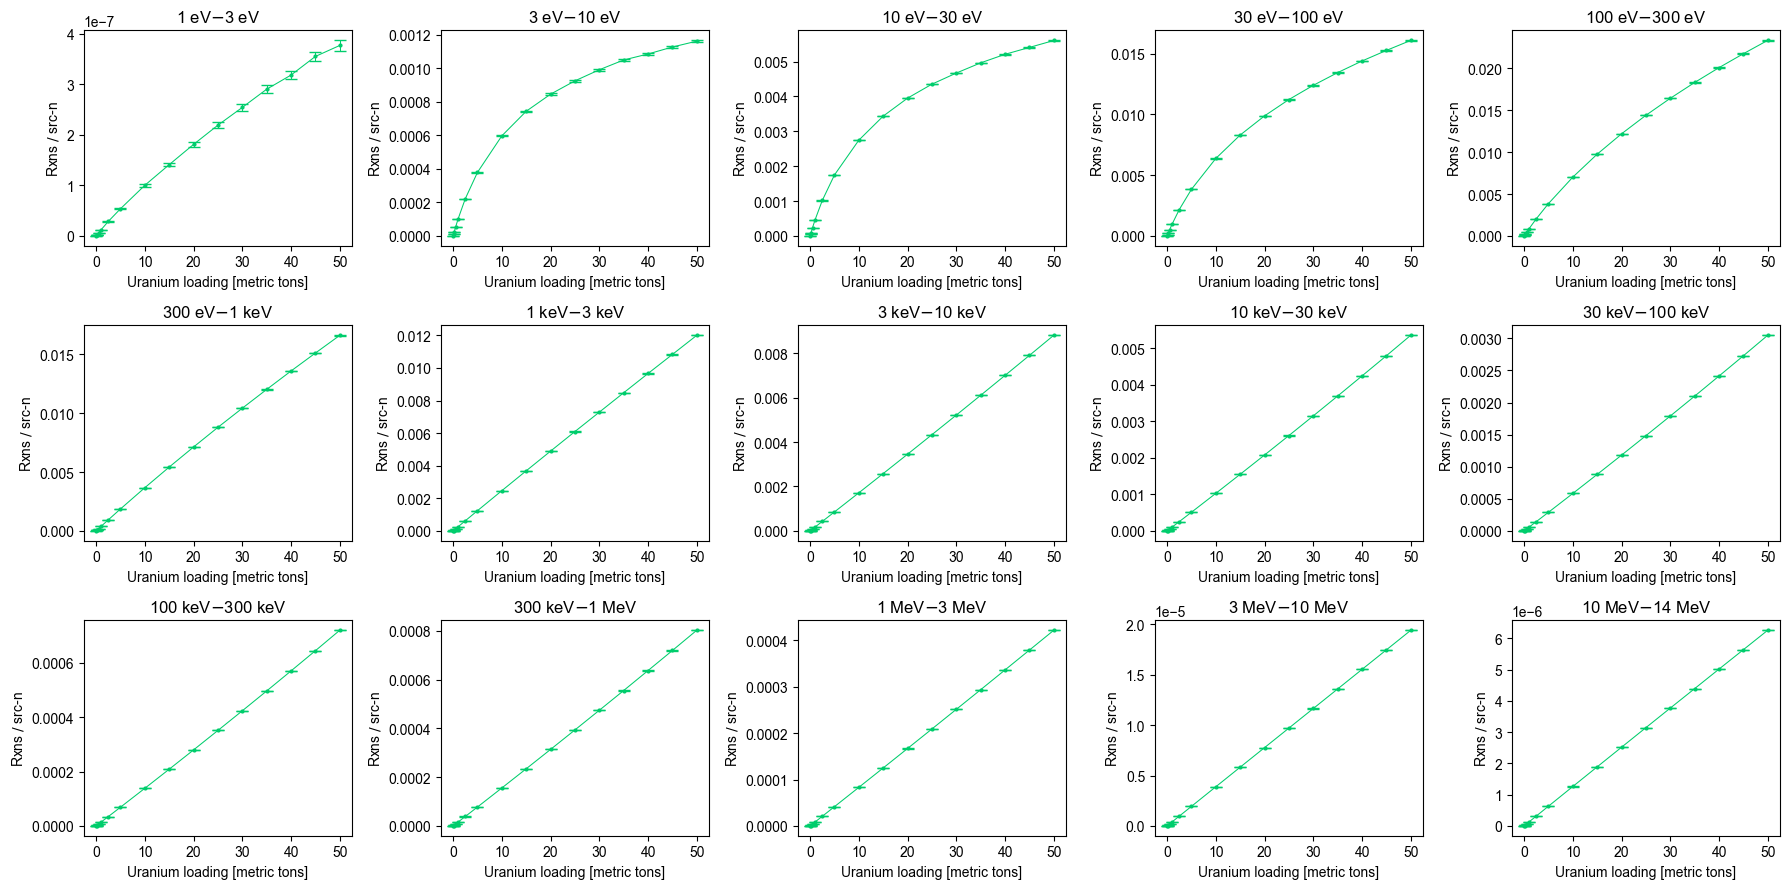

In [12]:
bins_dict = {
    r'1 eV$-$3 eV': (0.9, 3), # r'$--$' doesn't actually return proper en dash :(
    r'3 eV$-$10 eV': (3, 10), 
    r'10 eV$-$30 eV': (10, 30),
    r'30 eV$-$100 eV': (30, 100),
    r'100 eV$-$300 eV': (100, 300),
    r'300 eV$-$1 keV': (300, 1e3),
    r'1 keV$-$3 keV': (1e3, 3e3),
    r'3 keV$-$10 keV': (3e3, 10e3),
    r'10 keV$-$30 keV': (10e3, 30e3),
    r'30 keV$-$100 keV': (30e3, 100e3),
    r'100 keV$-$300 keV': (100e3, 300e3),
    r'300 keV$-$1 MeV': (300e3, 1e6),
    r'1 MeV$-$3 MeV': (1e6, 3e6),
    r'3 MeV$-$10 MeV': (3e6, 10e6),
    r'10 MeV$-$14 MeV': (10e6, 15e6),  }

""" 
Collate y-axis data 
  U238_abs_Ebin_XY should be a list of length len(MASS_U_LIST), 
  ex: XY = [xy_for_0mtu, xy_for_0.1mtu,..., xy_for_50mtu]
  where each xy_for_*mtu is a df of energies, mean, std. dev. 
"""
U238_abs_Ebin_XY = []
cells = U238_abs_Ebin_df['cell'].unique().tolist()
for c in cells:
    xy_to_add = U238_abs_Ebin_df[U238_abs_Ebin_df['cell'] == c][['energy mid [eV]','mean','std. dev.']]
    U238_abs_Ebin_XY.append(xy_to_add)

df_runs = {
    mass: df_mass
    for mass, df_mass in zip(MASS_U_LIST, U238_abs_Ebin_XY)
}

# Loop over each loading
sum_means = {label: [] for label in bins_dict}
sum_stds  = {label: [] for label in bins_dict}
for mass in MASS_U_LIST:
    dfm = df_runs[mass]
    # Loop over each energy bin
    for label, (emin, emax) in bins_dict.items():
        mask = dfm['energy mid [eV]'].between(emin, emax)
        sum_means[label].append(dfm.loc[mask, 'mean'].sum())
        sum_stds[label].append(dfm.loc[mask, 'std. dev.'].sum())

# TODO: Write this more elegantly with Tally.summation() and Tally.get_slice() lol --ppark
# U_tally.get_slice(nuclides=['U238'],scores=['(n,gamma)'], filters=[openmc.CellFilter,openmc.EnergyFilter], filter_bins=[(1,16),((1,3),)])

""" Plot """
# Prepare subplots: 3 rows x 5 columns for 15 bins
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(18,9))
axes = axes.flatten()

for ax, (label, (emin, emax)) in zip(axes, bins_dict.items()):
    ax.errorbar(MASS_U_LIST, sum_means[label], yerr=sum_stds[label], fmt='o-', markersize=2, capsize=4, linewidth=0.75, color='#00cd6c',) # turn capsize > 0 to show error bars, but they're super smol
    ax.set_title(label) #,fontsize=24)
    ax.tick_params(axis='both', which='major',) # labelsize=24)
    ax.set_xlabel('Uranium loading [metric tons]')
    ax.set_ylabel('Rxns $/$ src-n')

# Export figure
fig.tight_layout() # you need this here
plt.savefig(f'./figures/pdf/fig_u238ng_grid.pdf', bbox_inches='tight', format='pdf')
plt.savefig(f'./figures/png/fig_u238ng_grid.png', bbox_inches='tight', format='png') 
plt.show()